# MCT4001 Scientific Computing in Python Session 8
![mct-banner](https://raw.githubusercontent.com/wiki/MCT-master/Guides/assets/img/mct-banner.jpg)

In [1]:
# importing packages

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import sounddevice as sd
import librosa
import librosa.display
import math
import scipy
import time

#importing signal processing package from scipy (if not we have to specify scipy.signal)
from scipy import signal


# defining funtions that will be used in this notebook

def mySineSynth(freq, dur_ms, amp=1, pha=0, sr=48000):

    t = np.arange(0,dur_ms/1000,1/sr)
    s = amp*np.sin(2*np.pi*freq*t+pha)
    
    return s

def myPlotStem(signal,title):
    plt.figure(figsize=(10, 3))
    plt.stem(signal, use_line_collection=True)
    plt.grid(True)
    plt.xticks(range(0,signal.size))
    plt.ylim([-1,1])
    plt.title(title)
    plt.show()

def myPlotLine(signal,title):
    plt.figure(figsize=(10, 3))
    plt.plot(signal)
    plt.grid(True)
    plt.ylim([-1,1])
    plt.title(title)
    plt.show()
    
def mySpectrogram(s,sr,title):
    D = librosa.stft(s)
    DdB = librosa.amplitude_to_db(abs(D))
    plt.figure(figsize=(10, 3))
    librosa.display.specshow(DdB, sr=sr, x_axis='time', y_axis='hz')
    plt.title(title)
    plt.show()

def myWaveform(s,sr,title):
    plt.figure(figsize=(10, 3))
    librosa.display.waveplot(s, sr=sr)
    plt.title(title)
    plt.show()

def myFiltResponse(b,a,sr,title):
    w, h = scipy.signal.freqz(b,a)
    fig, ax1 = plt.subplots()
    ax1.set_title(title)
    ax1.plot(w/math.pi, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Normalized Frequency')
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w/math.pi, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.grid()
    ax2.axis('tight')
    plt.show()

def myFiltGroupDelay(b,a,sr,title):
    w, gd = scipy.signal.group_delay((b, a))
    plt.title(title)
    plt.plot(w/math.pi, gd)
    plt.ylabel('Group delay [samples]')
    plt.xlabel('Normalized Frequency')
    plt.show()


In [2]:
%config IPCompleter.greedy=True
%matplotlib inline

## Filter Design & Filtering Fucntions

In Scipy there is a rich collection of functions for [signal processing](https://docs.scipy.org/doc/scipy/reference/signal.html), including functions for **[Filtering](https://docs.scipy.org/doc/scipy/reference/signal.html#filtering)** and for **[Filter Design](https://docs.scipy.org/doc/scipy/reference/signal.html#filter-design)**. 

With **Filtering** we refer to the process of obtaining the filtered signal given the input signal and the filter coefficients.

With **Filter Design** we refer to the process of obtaining filter coefficients (*b* only for FIR - only numerator, *b* and *a* for IIR - both numerator and denominator coefficients) given fucntional parameters of the filters (such as the desired response in the frequency domain).

Generally we have to design a filter before being able to use it (filtering) one or multiple times.

Among available functions to design FIR filters there are:
* [firwin](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firwin.html#scipy.signal.firwin)
* [firwin2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firwin2.html#scipy.signal.firwin2)

Among available functions to design IIR filters there is:
* [iirdesign](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirdesign.html#scipy.signal.iirdesign)
* [MATLAB-style functions](https://docs.scipy.org/doc/scipy/reference/signal.html#matlab-style-iir-filter-design)

To filter a signal with a FIR or IIR, we can simply pass the filter coefficients to the function [lfilter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html#scipy.signal.lfilter). To compute the frequency response (already included in the myFiltResponse function) we can use the function [freqz](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.freqz.html#scipy.signal.freqz). 

After completing the work in this notebook, it is recommended that you also analyze and get familiar with the code of the functions *myFiltResponse* and *myFiltGroupDelay* (defined at the top of this notebook), and in particular with the methods [freqz](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.freqz.html) and scipy.signal and [group_delay](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.group_delay.html).


![FIR-IIR](https://www.stepbystep.com/wp-content/uploads/2013/04/Difference-Between-IIR-and-FIR-Filters.gif "FIR vs IIR")


In [3]:
#defining global sampling rate
sr = 48000


### 1. FIR

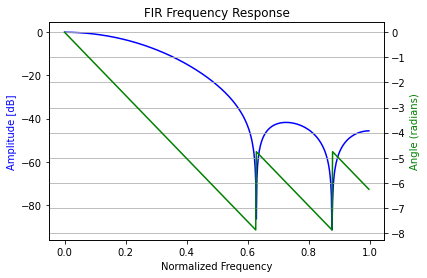

In [4]:
# designing low pass FIR filter with firwin

numtaps = 9 #filter lenght - the order of a FIR is (lenght-1)

f = 0.2 #cutoff normalized frequency, must between 0 and fs/2 (if not specified fs=2)

b = signal.firwin(numtaps, f, pass_zero=True)

# displaying response
myFiltResponse(b,1,sr,'FIR Frequency Response')


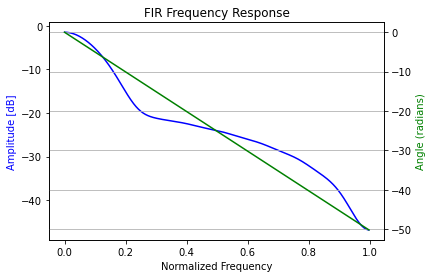

In [5]:
# designing low pass FIR filter with firwin2

numtaps = 33 #filter lenght

freqs = [0.0, 0.2, 1.0] #list of normalized frequency values (between 0 and 1, unless fs is specified)
                        # must start with 0 and finish with 2 (or fs/2 if fs specified)

gains = [1.0, 0.1, 0.0] #list of corresponding gain values (between 0 and 1)


b = signal.firwin2(numtaps, freqs, gains)

# displaying response
myFiltResponse(b,1,sr,'FIR Frequency Response')

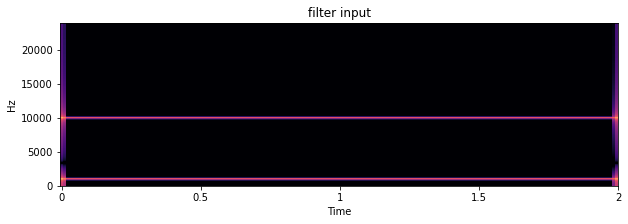

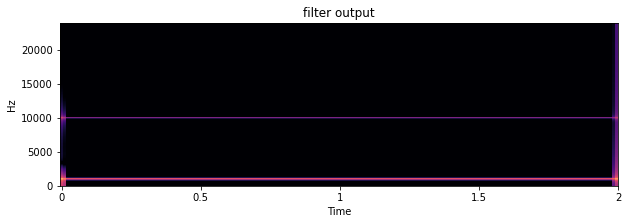

In [6]:
# testing the filter with a signal with two components

x = mySineSynth(freq=1000, dur_ms=2000, amp=0.5, pha=0, sr=sr) + \
     + mySineSynth(freq=10000, dur_ms=2000, amp=0.5, pha=0, sr=sr)


#alternatively we can try with white gaussina noise
#x = np.random.normal(0, 0.1, 2*sr)

# computing the output (this can be done also via convolution, is the same operation for a FIR)
y = signal.lfilter(b, 1, x)

#displaying results
mySpectrogram(x, sr, 'filter input')
mySpectrogram(y, sr, 'filter output')

#myWaveform(x, sr, 'filter input')
#myWaveform(y, sr, 'filter output')


In [7]:
sd.play(x,sr)
sd.wait()
sd.play(y,sr)
sd.wait()

### 2. IIR

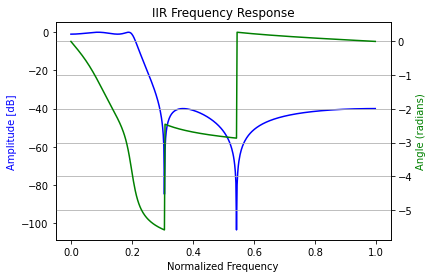

In [8]:
# designing low pass IIR filter with iirdesign
# we cannot specify the order here, but we get the minimum order satisfying the requirements

wp = 0.2 # passband edge frequency
ws = 0.3 # stopband edge frewuency
gpass = 1 # maximum loss in the passband (dB).
gstop = 40 # minimum attenuation in the stopband (dB).

[b,a] = signal.iirdesign(wp, ws, gpass, gstop)

# displaying response
myFiltResponse(b,a,sr,'IIR Frequency Response')

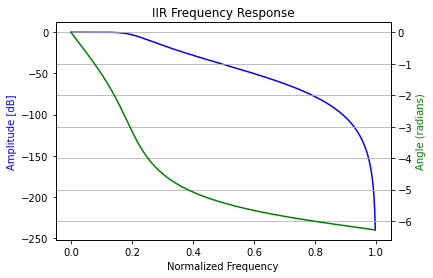

In [9]:
# designing low pass IIR filter with one of the MATLAB-style functions (we can specify the order)

order = 4
fc = 0.2 # cutoff normalizd frequency

b,a = signal.butter(order, fc, 'low', analog=False)

# displaying response
myFiltResponse(b,a,sr,'IIR Frequency Response')

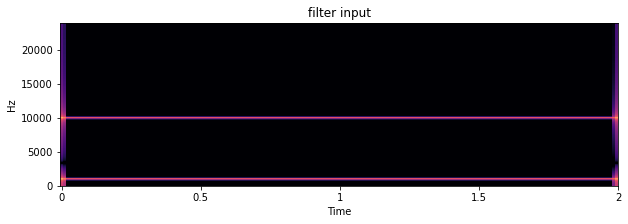

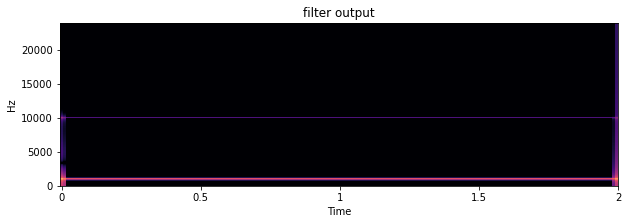

In [10]:
# testing the filter with a signal with two components

x = mySineSynth(freq=1000, dur_ms=2000, amp=0.5, pha=0, sr=sr) + \
     + mySineSynth(freq=10000, dur_ms=2000, amp=0.5, pha=0, sr=sr)


#alternatively we can try with white gaussina noise
#x = np.random.normal(0, 0.1, 2*sr) #this generates 2 seconds (2 x sampling rate samples) of white noise

# computing the output
y = signal.lfilter(b, a, x)

#displaying results
mySpectrogram(x, sr, 'filter input')
mySpectrogram(y, sr, 'filter output')

#myWaveform(x, sr, 'filter input')
#myWaveform(y, sr, 'filter output')


In [11]:
sd.play(x,sr)
sd.wait()
sd.play(y,sr)
sd.wait()


#### Task 1

Design one FIR and one IIR high-pass filter with similar response (i.e. pass-band, stop-band, cutoff frequency) using one of the design techniques used above. Display their frequency responses and use the filter to process white noise. Display the spectrogram of the signal before and after filtering. Compare the filtered noise and the response from both filters against their order (focus on attenuation level in the pass-band, stop, band, and at the cutoff). Try to alter on the order to get a more similar response.

*Optional* (i.e. if you complete the above quickly). Try to design a band stop filter (both FIR and IIR).

## 2. Phase Considerations

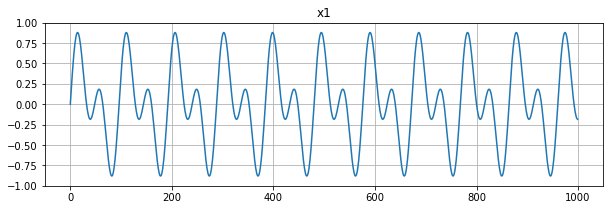

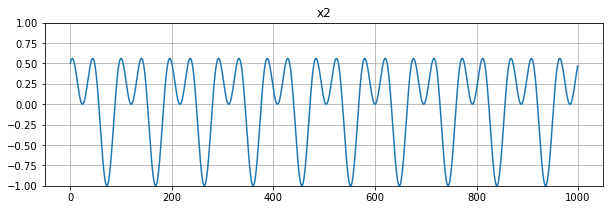

In [12]:
# showing two signals with identical frequency components but different phase
# waveforms look different, signals sound identical (our ears are "phase deaf")

sr = 48000

x1 = mySineSynth(freq=500, dur_ms=2000, amp=0.5, pha=0, sr=sr) + \
     + mySineSynth(freq=1000, dur_ms=2000, amp=0.5, pha=0, sr=sr)

x2 = mySineSynth(freq=500, dur_ms=2000, amp=0.5, pha=0, sr=sr) + \
     + mySineSynth(freq=1000, dur_ms=2000, amp=0.5, pha=math.pi/2, sr=sr)

# plotting only the first 1000 samples to show the difference  in the waveform
myPlotLine(x1[0:1000],'x1')
myPlotLine(x2[0:1000],'x2')


In [13]:
# although the waveforms look different, we do not hear any difference (humand are phase deaf).
sd.play(x1,sr)
sd.wait()
sd.play(x2,sr)
sd.wait()


The **group delay** is a  measure of the linearity of the phase with respect to frequency in a modulation system (it is the first order derivative of the phase response - green line in filter response, which tells us how "straight" is that line, then the group delay is a flat line, the phase response is perfectly linear). The group delay does not indicte the overall latency/delay of a filter, bur rather the rate of change of the phase around this point in frequency. In general FIR *can* have a linear phase (not granted), IIR are not linear phase (they can be close to it). This implies some phase distortion at the output of an IIR (i.e. different frequency components will be delayed by a different amount of time, this is so small that is hard to hear).

FIR order =  8


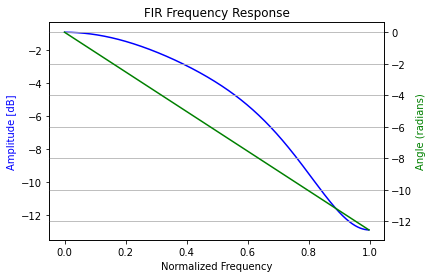

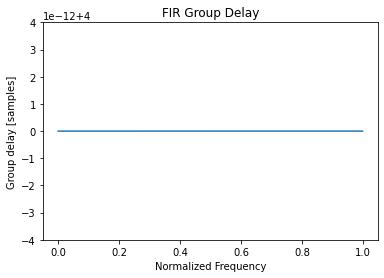

IIR order =  3


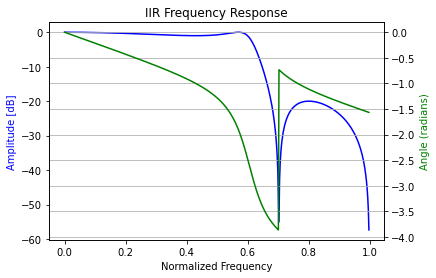

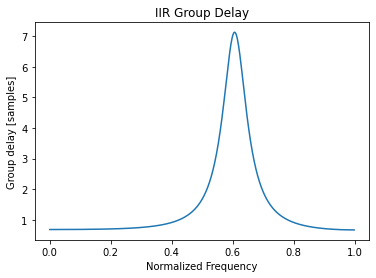

In [14]:
# FIR  vs IIR group delay

# FIR
b = signal.firwin2(numtaps=9, freq=[0.0, 0.7, 1.0], gain=[1.0, 0.5, 0.0])

print('FIR order = ',b.size-1)
myFiltResponse(b,1,sr,'FIR Frequency Response')
myFiltGroupDelay(b,1,sr,'FIR Group Delay')


# IIR
[b,a] = signal.iirdesign(wp=0.6, ws=0.8, gpass=1, gstop=20)

print('IIR order = ',b.size-1)
myFiltResponse(b,a,sr,'IIR Frequency Response')
myFiltGroupDelay(b,a,sr,'IIR Group Delay')


Given a linear phase FIR filter which has N taps, the **delay** is: (N – 1) / 2 samples. If you wish to compute the delay in seconds use (N – 1) / (2 * Fs), where Fs is the sampling frequency. So, for example, a 21 tap linear-phase FIR filter operating at a 1 kHz rate has delay: (21 – 1) / (2 * 1 kHz) = 10 milliseconds.

IIR filters has negligible delay, usually just a few samples and this is independent of the order.

The above are clearly visible when using the filter when the input is a simple impulse (due to the "filtering" the impulse will look "wider", just focus on the peak).

FIR order =  8


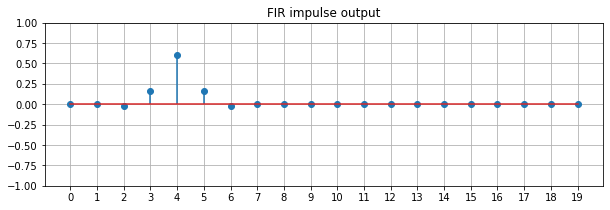

IIR order =  3


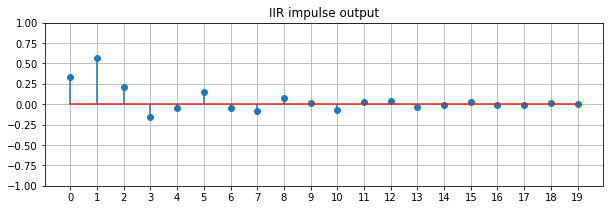

In [15]:
# creating an impulse signal which includes only an impulse
impulse = np.zeros((20))
impulse[0] = 1

# filtering the impulse with a FIR
b = signal.firwin2(numtaps=9, freq=[0.0, 0.7, 1.0], gain=[1.0, 0.5, 0.0])
y = signal.lfilter(b, 1, impulse)
print('FIR order = ',b.size-1)
myPlotStem(y,'FIR impulse output')

# filtering the impulse with an IIR
[b,a] = signal.iirdesign(wp=0.6, ws=0.8, gpass=1, gstop=20)
y = signal.lfilter(b, a, impulse)
print('IIR order = ',b.size-1)
myPlotStem(y,'IIR impulse output')

#### Task 2

- Experiment with FIR and IIR filters of different order to explore their latency/delay (use an impulse as input or any other signal you consider appropriate). For IIRs, signal.iirdesign does not allow to specify the filter order,but you can increase it requiring a "more selective" filter (or use the MATLAB-style functions which allow specifying the order).

- Verify that for a FIR filters:
    - You can obtain the same filter output by performing the convolution between the filter coefficients (*b* in the notebook, which represents the coefficients of the impulse response) and the input (other than using *signal.lfilter*)
    - When the input of the filter if an impulse, the output is the actual impulse response (i.e. the *b* coefficients). Try to reconcile this with the FIR computational structure(https://www.researchgate.net/profile/Nishant-Kumar-29/publication/261213826/figure/fig3/AS:667639995174912@1536189187149/Block-Diagram-of-a-FIR-Filter.png), where *z-1* represents a delay of one sample.